In [1]:
from binpack.models import Result
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.stats import descriptivestats

In [2]:
results = Result.objects.filter(n_tiles=20, improved_sel=True)

In [3]:
results.values('score')

<QuerySet [{'score': 0.0}, {'score': 0.0}, {'score': 1.0}, {'score': 0.0}, {'score': 0.0}, {'score': 0.0}, {'score': 0.0}, {'score': 2.0}, {'score': 1.0}, {'score': 0.0}, {'score': 0.0}, {'score': 0.0}, {'score': 0.0}, {'score': 0.0}, {'score': 0.0}, {'score': 1.0}, {'score': 1.0}, {'score': 0.0}, {'score': 0.0}, {'score': 0.0}, '...(remaining elements truncated)...']>

In [4]:
def calc_p_value(results, max_depth_instances, avg_depth_instances, is_guillotine=True): 
    max_depth_wins = 0
    avg_depth_wins = 0
    draws = 0
    values = []
    for max_depth_res in max_depth_instances:
        if is_guillotine:
            kwargs = {'problem_id': max_depth_res.problem_id}
        else:
            kwargs = {'their_id': max_depth_res.their_id}
        kwargs['score__isnull'] =  False
        avg_depth_res = results.filter(
            strategy='avg_depth',
            **kwargs,
            )
        if avg_depth_res.count() == 1:
            avg_depth_score = avg_depth_res.first().score
            max_depth_score = max_depth_res.score
            if avg_depth_score > max_depth_score: # lower is better
                max_depth_wins +=1 
                values.append(1)
            elif avg_depth_score < max_depth_score:
                avg_depth_wins += 1
                values.append(-1)
            else:
                draws += 1
                
    print(f'In total max_depth_wins: {max_depth_wins}, avg_depth_wins: {avg_depth_wins}, and {draws} ties.')
    
    m = descriptivestats.sign_test(values)
    print(f'p value: {m[1]}')

In [11]:
'''
gets problem_id's of problems which were solved by all variations
'''
def get_best_problem_ids(N=1000, guillotine=True):
    ret = []
    common_args = {'solution_tiles_order__isnull': True, 'improved_sel': True, 'score__isnull': False}
    problem_ids = set()
    for r in Result.objects.filter(n_simulations=5000, **common_args):
        if guillotine:
            common_args['problem_generator'] = 'guillotine'
            count = len(set(Result.objects.filter(problem_id=r.problem_id, **common_args).values_list('strategy', 'n_simulations')))
            problem_ids.add((r.problem_id, count))
        else:
            common_args['problem_generator'] = 'florian'
            count = len(set(Result.objects.filter(their_id=r.their_id, **common_args).values_list('strategy', 'n_simulations')))
            problem_ids.add((r.their_id, count))
            
    problem_ids = sorted(problem_ids, key=lambda x: x[1])
    N_COMBINATIONS = 12 # 100, 200, 500, 1k, 2k, 5k for avg and max depth
    ret =  [x[0] for x in problem_ids if x[1] == N_COMBINATIONS]
    return ret[:1000]

In [12]:
best_problem_ids = get_best_problem_ids()
best_their_ids = get_best_problem_ids(guillotine=False)

In [7]:
def eliminate_duplicate_tiles(tiles):
    i = 0
    new_tiles = []
    while i < len(tiles):
        tile = tiles[i]
        tiles_without_current_tile = tiles[i + 1:]
        tile_pair_index = tiles_without_current_tile.index([tile[1], tile[0]]) + i + 1
        tiles = tiles[0: tile_pair_index] + tiles[tile_pair_index + 1:]
        i += 1 
    return tiles

b_problems = Result.objects.filter(their_id__in=best_their_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols', 'tiles', 'n_tiles', 'their_id')
all_lists = list(b_problems.values_list('tiles', flat=True))
_all_list_strs = []
for l in all_lists:
    _all_list_strs.append(str(sorted(l)))
print(len(set(_all_list_strs)))
# print(_all_list_strs)

# check if any list contains duplicates inside
for l in all_lists:
    # print(l)
    #l = eliminate_duplicate_tiles(l)
    _l = [tuple(x) for x in l]
    # print(_l)
    new_set = set()
    for el in _l:
        new_set.add(el)
    if len(new_set) != 40:
        print('duplicate found')
        

1000


In [92]:
'''
visualize solutions
'''
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

def visualize_grid(grid, rows, cols, lines_tiles=None):
    import matplotlib
    #matplotlib.use('GTK')
    np.random.seed(4)

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.set_xticks(list(range(cols)))
    ax1.set_yticks(list(range(rows)))
    ax1.grid(True)
    print(lines_tiles)
    x1margin = -0.5
    y1margin = -0.5
    if lines_tiles:
        for line in lines_tiles:
            new_line = []
            for point in line:
                point = (point[0] + x1margin, point[1] + y1margin)
                new_line.append(point)
            path = matplotlib.patches.Polygon(new_line, facecolor='none', edgecolor='black',
                                   linewidth=5, closed=True, joinstyle='round')
            ax1.add_patch(path)
    
    lines = [
        [(0.5, -0.4), (cols -.5, -0.4), (cols -.5, rows -.4), (0.5, rows -.4)]]
            
    
    for line in lines:
        path = matplotlib.patches.Polygon(line, facecolor='none', edgecolor='black',
                               linewidth=8, closed=True, joinstyle='round')
        ax1.add_patch(path)
    # https://matplotlib.org/3.1.3/tutorials/colors/colormaps.html
    ax1.imshow(grid, cmap=matplotlib.cm.get_cmap('gist_ncar'))
    fig1.subplots_adjust(left=0,right=0.9,bottom=0,top=0.9)
    plt.axis('off')
    plt.xlim(0, cols)
    plt.ylim(0, rows)
    ax1.set_xlim(0.4, cols -.35)
    ax1.set_ylim(-0.5, rows -.3)
    plt.figure(1)
    plt.show()
    plt.close()
visualize_problem_from_tiles(problem)

NameError: name 'visualize_problem_from_tiles' is not defined

In [ ]:
import datetime, json
from solution_checker import SolutionChecker
problems = Result.objects.filter(created_on__gte=datetime.datetime(2020, 3, 4), solution_found=True, score=0, n_tiles=20, problem_generator='guillotine')
seen = set()
for problem in problems[:20]:
    if (problem.cols, problem.rows) in seen:
        continue
    else:
        seen.add((problem.cols, problem.rows))
    try:
        visualize_problem_from_tiles(problem)
    except:
        pass
def visualize_problem_from_tiles(problem):
    grid = np.zeros((problem.rows, problem.cols))
    tiles = json.loads(problem.solution_tiles_order)
    color_o, color_e = 1, 20
    lines = []
    for i, tile in enumerate(tiles):
        if i % 2 == 0:
            color = color_o
            color_o += 1
        else:
            color = color_e
            color_e -= 1
        next_lfb = SolutionChecker.get_next_lfb_on_grid(grid)
        success, grid = SolutionChecker.place_element_on_grid_given_grid(
            tile, next_lfb, color, grid, problem.cols, problem.rows)
        y, x = next_lfb
        lines.append([(x, y), (x+tile[1], y), (x + tile[1], y + tile[0]), (x, y+tile[0])])
        visualize_grid(grid, problem.rows, problem.cols, lines)
    visualize_grid(grid, problem.rows, problem.cols, lines)
visualize_problem_from_tiles(problem)

In [ ]:
import json
from solution_checker import SolutionChecker
easy_ones = [
    'results/20.0_10_10__1000_tree.json',
    'results/20.0_20_13__1000_tree.json',
    'results/20.0_10_24__5000_tree.json',
    'results/20.0_11_11__5000_tree.json',
]
hard_b_ones =  [
    'results/20.0_15_28__5000_tree.json',
]
def visualize_problem(height, width):
    problem_file = easy_ones[0]
    #problem_file = hard_b_ones[0]
    with open(f'results/20.0_{width}_{height}__5000_tree.json', 'r') as f:
        tree = json.loads(f.read())

    import copy
    initial_grid = copy.deepcopy(tree['board'])
    print(len(initial_grid))
    color_o = 0
    tilesis_over = False
    color_switch = 0
    while True:
        color_switch += 1
        if color_switch % 2 == 0:
            color = color_e
            color_e -= 1
        else:
            color = 20 - color_o
            color_o += 1
        for i, row in enumerate(tree['board']):
            for j, col in enumerate(row):
                if initial_grid[i][j] == 0 and col == 1:
                    initial_grid[i][j] = color
        if color_switch == 3:
            '''
            the solution skips one state here. need to create it.
            we do it by iterating over the tile in LFB
            '''

            i = next_lfb[0]
            j = next_lfb[1]
            i1, j1 = SolutionChecker.get_next_lfb_on_grid(np.array(tree['board']))
            while initial_grid[i+1] == initial_grid[i+1][j1]:  # go all the way upto top
                i += 1
            if initial_grid[i+1][j] != initial_grid[i+1][j1]:
                if initial_grid[i+1][j] == 0:
                    # left tile is smaller
                    while initial_grid[i+1][j] == 0:
                        j += 1
                    col_to_point_on = j - 1
                else:
                    while initial_grid[i+1][j] != 0:
                        j += 1
                    col_to_point_on = j - 1
            if col_to_point_on:
                for _i in range(next_lfb[0], len(tree['board'])):
                    for _j in range(col_to_point_on, len(tree['board'][0])):
                        if initial_grid[_i][_j] != 0:
                            initial_grid[_i][_j] = color_o
                color_o += 1
            else:
                continue
        # visualize_grid(initial_grid, len(initial_grid), len(initial_grid[0]))

        next_lfb = SolutionChecker.get_next_lfb_on_grid(np.array(initial_grid))
        if is_over:
            break
        if tree['children']:
            is_over=True
            for child in tree['children']:
                if child['children']:
                    tree = child
                    is_over = False
                    break
            # print(color)
            #print(tree['board'])
            # visualize_grid(initial_grid, len(initial_grid), len(initial_grid[0]))
        else:
            #print(initial_grid, color)
            #print(tree['board'])
            break

    visualize_grid(initial_grid, len(initial_grid), len(initial_grid[0]))

        # tree = child
        #if child['children']:
        #    tree = child


In [ ]:
'''
Output just problems to csvs
'''
g_problems = Result.objects.filter(problem_id__in=best_problem_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols', 'tiles', 'n_tiles')

b_problems = Result.objects.filter(their_id__in=best_their_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols', 'tiles', 'n_tiles', 'their_id')

       
import csv, os
for file_name, problems in [('problems_g.csv', g_problems), ('problems_b.csv', b_problems)]:
    with open(os.path.join('problems/', file_name), 'w') as csv_file:
        fieldnames = ['rows', 'cols', 'tiles', 'n_tiles']
        if file_name == 'problems_b.csv':
            fieldnames.append('external_id')
        csv_writer = csv.writer(csv_file, delimiter=';')
        csv_writer.writerow(fieldnames)
        for problem in problems:
            row = [problem['rows'], problem['cols'],
                   str(eliminate_duplicate_tiles(problem['tiles'])), problem['n_tiles']]
            if file_name == 'problems_b.csv':
                row.append(problem['their_id'])
            csv_writer.writerow(row)


In [ ]:
'''
Output problems to F. Braam solver csv style
'''
g_problems = Result.objects.filter(their_id__in=best_their_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols', 'tiles', 'n_tiles', 'problem_id', 'id')
      
import json
def tiles_to_braam_json(tiles):
    _tiles = []
    for tile in tiles:
        x = tile[0]
        y = tile[1]
        if tile[0] > tile[1]:
            x = tile[0]
            y = tile[1]
        else:
            x = tile[1]
            y = tile[0]
        _tiles.append({'X': x, 'Y': y})
    _tiles_str = json.dumps(_tiles)
    _tiles_str =  _tiles_str.replace(' ', '')
    return _tiles_str
    
import csv, os
for file_name, problems in [('problems_b_braam.csv', g_problems)]:
    with open(os.path.join('problems/', file_name), 'w') as csv_file:
        fieldnames = ['job_id', 'puzzle_id', 'num_tiles', 'board_width', 'board_height', 'tiles', 'start', 'end', 'problem_id']
        csv_writer = csv.writer(csv_file, delimiter=',' , quoting=csv.QUOTE_ALL)
        csv_writer.writerow(fieldnames)
        for i, problem in enumerate(problems):
            tiles = eliminate_duplicate_tiles(problem['tiles'])
            tiles = tiles_to_braam_json(tiles)
            row = [
                problem['id'], problem['id'], problem['n_tiles'],
                problem['rows'], problem['cols'],
                   tiles,
                "", "", problem['problem_id']
            ]
            csv_writer.writerow(row)


In [ ]:
'''
Output problems with results to csv
'''

N_SIM = [100, 200, 500, 1000, 2000, 5000]

import csv, os
for file_name in ['results_g.csv', 'results_b.csv']:
    # find same problem instances
    with open(os.path.join('csv_results/', file_name), 'w') as csv_file:
        print('*' * 50)
        fieldnames = ['rows', 'cols', 'tiles', 'n_tiles',
                      'strategy', 'n_simulations', 'score',
                      'solution_found',  'n_tiles_placed', 'created_on']
        if file_name == 'results_b.csv':
            fieldnames.append('external_id')
        csv_writer = csv.writer(csv_file, delimiter=';')
        csv_writer.writerow(fieldnames)
        for n_sim in N_SIM:
            if file_name == 'results_g.csv':
                problems = Result.objects.filter(
                    problem_id__in=best_problem_ids, n_simulations=n_sim, 
                    improved_sel=True, score__isnull=False
                ).values()
            else:
                problems = Result.objects.filter(
                    their_id__in=best_their_ids, n_simulations=n_sim, 
                    improved_sel=True, score__isnull=False
                ).values()

            for problem in problems:
                row = [problem['rows'], problem['cols'],
                       str(eliminate_duplicate_tiles(problem['tiles'])), problem['n_tiles']]
                for fieldname in fieldnames[4:-1]:
                    row.append(problem[fieldname])
                if file_name == 'results_b.csv':
                    row.append(problem['their_id'])
                csv_writer.writerow(row)


In [ ]:
import pandas as pd
print(len(best_problem_ids))
rows_cols = Result.objects.filter(problem_id__in=best_problem_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('rows', 'cols')
print(len(rows_cols))
print(type(rows_cols))
rows_cols = [{'rows': x['rows'], 'cols': x['cols']} for x in rows_cols]
df = pd.DataFrame(rows_cols)
matrix = np.zeros((41, 41))
for v in rows_cols:
    matrix[v['rows'], v['cols']] += 1
matrix = matrix[10:, 10:]
plt.figure(figsize=(8,8))
plt.title('G instances: rows, columns distribution')
pd = pd.DataFrame(matrix, columns=range(10, 41), index=range(10, 41))
sns.heatmap(pd, cmap='YlGnBu')
plt.ylabel('rows')
plt.xlabel('columns')

In [ ]:
tiles = Result.objects.filter(problem_id__in=best_problem_ids, n_simulations=5000, 
                                 improved_sel=True, strategy='max_depth', score__isnull=False
                                 ).values('tiles')

from collections import defaultdict
tiles_count = defaultdict(int)
for tile_dict in tiles:
    _tiles = tile_dict['tiles']
    for one_tile in _tiles:
        if one_tile[0] == one_tile[1]:
            tiles_count[(one_tile[0], one_tile[1])] += 1
            
print('Count of squares in problems:', tiles_count)

            
    
    

In [ ]:
print(len(best_problem_ids))
print(len(best_their_ids))

In [ ]:
'''
How many problems have duplicate tiles?
How many problems have squares?
How many problems have tiles bigger than col or width?
'''

from collections import defaultdict
def has_squares(tiles, with_1_1=False):
    for tile in tiles:
        if tile[0] == tile[1]:
            if with_1_1 and tile[0] == 1:
                continue
            else:
                return True
    return False

def has_duplicates(tiles, ignore_squares=False):
    tiles_count = defaultdict(int)
    for tile in tiles:
        str_tile = str(tile)
        tiles_count[str_tile] += 1
        if tiles_count[str_tile] > 2 and tile[0] == tile[1]:
            return True
        if tiles_count[str_tile] > 1 and tile[0] != tile[1]:
            return True
    return False

def has_tile_bigger_than_width_height(tiles, rows, cols):
    for tile in tiles:
        if tile[0] > rows or tile[1] > cols or tile[0] > cols or tile[1] > rows:
            return True
    return False

In [ ]:
common_args = {'problem_generator': 'guillotine', 'improved_sel': True, 'n_simulations': 1000}
g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', **common_args)
distinct_problems = g_max_depth_instances.values('tiles', 'cols', 'rows').distinct()

n_with_squares = 0
n_with_squares_excluding_1_1 = 0
n_with_duplicates = 0
n_with_duplicates_ign_s = 0
n_tile_bigger_than_width_height = 0
n_frames_that_cannot_accomodate = 0
computed_problems = set()
for problem in distinct_problems:
    problem_str = (problem['cols'], problem['rows'], str(problem['tiles']))
    if problem_str in computed_problems:
        continue
    else:
        computed_problems.add(problem_str)
    if has_squares(problem['tiles']):
        n_with_squares += 1
    if has_squares(problem['tiles'], with_1_1=True):
        n_with_squares_excluding_1_1 += 1
    if has_duplicates(problem['tiles']):
        n_with_duplicates += 1
    if has_duplicates(problem['tiles'], ignore_squares=True):
        n_with_duplicates_ign_s += 1
    if has_tile_bigger_than_width_height(problem['tiles'], problem['rows'], problem['cols']):
        n_frames_that_cannot_accomodate += 1
    
print(f'G problems with squares: {n_with_squares}')
print(f'G problems with squares (ignoring (1, 1) tile): {n_with_squares_excluding_1_1}')
print(f'G problems with duplicate tiles: {n_with_duplicates}')
print('G problems with frames that cannot accomodate '
      f'all tiles both horizontally and vertically: {n_frames_that_cannot_accomodate}')

In [ ]:
def visualize_qs(qs):
    for p in qs:
        try:
            print(p.rows, p.cols)
            visualize_problem(p.rows, p.cols)
        except Exception as e:
            print(f'Exceeption {e} occurred')

In [ ]:
'''
Finding the hardest problems for 5000 simulations
'''
def print_scores(scores):
    for p in scores:
        print(f'(score)unplaced_tiles: {p.score}; placed_tiles: {p.n_tiles_placed}; height: {p.rows}; width: {p.cols}; tiles: {p.tiles}')
    
common_args = {'problem_generator': 'guillotine', 'improved_sel': True, 'n_simulations': 5000}

g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', score__isnull=False, **common_args)
g_avg_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', score__isnull=False, **common_args)

max_depth_worst_score = g_max_depth_instances.order_by('score').last().score
avg_depth_worst_score = g_avg_depth_instances.order_by('score').last().score

g_max_depth_instances = g_max_depth_instances.filter(score=max_depth_worst_score).order_by('-n_tiles_placed')
print('Hardest G max_depth problems:')
print_scores(g_max_depth_instances)
print()
g_avg_depth_instances = g_avg_depth_instances.filter(score=avg_depth_worst_score).order_by('-n_tiles_placed')
print('Hardest G avg_depth problems:')
print_scores(g_avg_depth_instances)

print()
print('Easiest 3 G avg_depth problems:')
g_avg_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', solution_found=True, **common_args).order_by('n_tiles_placed')
print_scores(g_avg_depth_instances[:3])

print()
print('Easiest 3 G max_depth problems:')
g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', solution_found=True, **common_args).order_by('n_tiles_placed')
print_scores(g_max_depth_instances[:20])
visualize_qs(g_avg_depth_instances[:20])

print()
print('Hardest solved G max_depth problems:')
g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', solution_found=True, score=0, **common_args).order_by('-n_tiles_placed')
visualize_qs(g_max_depth_instances[:40])

print('*' * 100)
print('Hardest solved G avg_depth problems:')
g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', solution_found=True, score=0, **common_args).order_by('-n_tiles_placed')
visualize_qs(g_max_depth_instances[:40])


print()
print('Interestingly the easiest avg_depth and max_depth problems have same number of placed_tiles (for upto 326 easiest problems) which means the strategies do not make a difference during the search.')

In [ ]:
common_args = {'problem_generator': 'florian', 'improved_sel': True, 'n_simulations': 5000, 'their_id__in':best_their_ids}

g_max_depth_instances = Result.objects.filter(strategy='max_depth', score__isnull=False, **common_args)
g_avg_depth_instances = Result.objects.filter(strategy='avg_depth', score__isnull=False, **common_args)

max_depth_worst_score = g_max_depth_instances.order_by('score').last().score
avg_depth_worst_score = g_avg_depth_instances.order_by('score').last().score

g_max_depth_instances = g_max_depth_instances.filter(score=max_depth_worst_score).order_by('-n_tiles_placed')
print('Hardest B max_depth problems:')
print_scores(g_max_depth_instances)
print()
g_avg_depth_instances = g_avg_depth_instances.filter(score=avg_depth_worst_score).order_by('-n_tiles_placed')
print('Hardest B avg_depth problems:')
print_scores(g_avg_depth_instances)

print()
print('Easiest 3 B avg_depth problems:')
g_avg_depth_instances = Result.objects.filter(strategy='avg_depth', solution_found=True, **common_args).order_by('n_tiles_placed')
print_scores(g_avg_depth_instances[:3])
visualize_qs(g_avg_depth_instances[:10])

print()
print('Easiest 3 B max_depth problems:')
g_max_depth_instances = Result.objects.filter(strategy='max_depth', solution_found=True, **common_args).order_by('n_tiles_placed')
print_scores(g_max_depth_instances[:3])
visualize_qs(g_max_depth_instances[:10])

In [13]:
common_args = {'problem_generator': 'florian', 'improved_sel': True, 'solution_tiles_order__isnull': True}

N_SIM = [100, 200, 500, 1000, 2000, 5000]

# find same problem instances
for n_sim in N_SIM:
    print('*' * 50)
    print(f'SIMULATIONS: {n_sim}')
    print('*' * 50)
    common_args['problem_generator'] = 'guillotine'
    common_args['n_simulations'] = n_sim
    common_args['score__isnull'] = False

    g_max_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', **common_args)
    g_avg_depth_instances = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', **common_args)

    print('Guillotine:')
    calc_p_value(Result.objects.filter(problem_id__in=best_problem_ids, **common_args), g_max_depth_instances, g_avg_depth_instances)

    common_args['problem_generator'] = 'florian'
    ng_avg_depth_instances = Result.objects.filter(strategy='avg_depth', their_id__in=best_their_ids,  **common_args)
    ng_max_depth_instances = Result.objects.filter(strategy='max_depth', their_id__in=best_their_ids, **common_args)
    ng_avg_depth_scores = ng_avg_depth_instances.values('score')
    ng_max_depth_scores = ng_max_depth_instances.values('score')

    print('Non-guillotine:')
    calc_p_value(Result.objects.filter(**common_args), ng_max_depth_instances, ng_avg_depth_instances, is_guillotine=False)

    # scores = results.values('score', 'strategy')
    # print(np.average(np.array(results.filter(score__isnull=False, strategy='avg_depth', **common_args).values_list('rows', flat=True))))
    # print(np.average(np.array(results.filter(score__isnull=False, strategy='max_depth', **common_args).values_list('rows', flat=True))))

**************************************************
SIMULATIONS: 100
**************************************************
Guillotine:
In total max_depth_wins: 140, avg_depth_wins: 251, and 609 ties.
p value: 2.1496875689785453e-08
Non-guillotine:
In total max_depth_wins: 460, avg_depth_wins: 147, and 393 ties.
p value: 1.779265443397546e-38
**************************************************
SIMULATIONS: 200
**************************************************
Guillotine:
In total max_depth_wins: 158, avg_depth_wins: 220, and 622 ties.
p value: 0.0016683996441579617
Non-guillotine:
In total max_depth_wins: 519, avg_depth_wins: 126, and 355 ties.
p value: 1.5916434762892756e-57
**************************************************
SIMULATIONS: 500
**************************************************
Guillotine:
In total max_depth_wins: 161, avg_depth_wins: 188, and 651 ties.
p value: 0.1639045475301828
Non-guillotine:
In total max_depth_wins: 575, avg_depth_wins: 102, and 323 ties.
p value: 6.9525

In [30]:
def score_to_int(df):
    df['score'] = df['score'].astype('int')
    return df

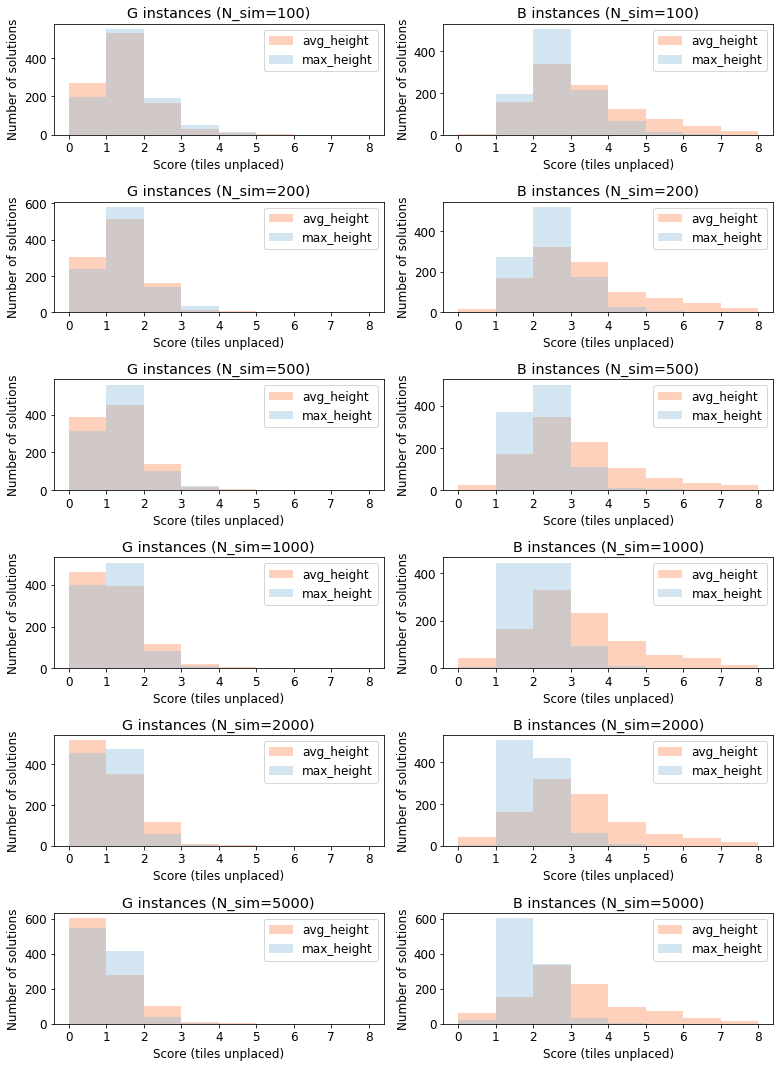

In [31]:
# scores_df
N_SIM = [100, 200, 500, 1000, 2000, 5000]
plt.rcParams.update({'font.size': 12})
f, axes = plt.subplots(len(N_SIM), 2, figsize=(11, 15))
for j, n_sim in enumerate(N_SIM):
    common_args = {
        'score__isnull': False, 'improved_sel': True,
        'n_simulations': n_sim
    }
    bins = np.arange(0, 9)
    rows = len(N_SIM) // 2
    for i in range(2):
        if i == 0:
            common_args['problem_generator'] = 'guillotine'
            title = f'G instances (N_sim={n_sim})'
            avg_depth_scores = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', **common_args).values('score')
            max_depth_scores = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', **common_args).values('score')
        else:
            title = f'B instances (N_sim={n_sim})'
            common_args['problem_generator'] = 'florian'
            avg_depth_scores = Result.objects.filter(their_id__in=best_their_ids, strategy='avg_depth', **common_args).values('score')
            max_depth_scores = Result.objects.filter(their_id__in=best_their_ids, strategy='max_depth', **common_args).values('score')

        sns.distplot(score_to_int(pd.DataFrame.from_records(avg_depth_scores)),
                     kde=False, color='#fc8d59', label='avg_height', bins=bins, ax=axes[j][i])
        sns.distplot(score_to_int(pd.DataFrame.from_records(max_depth_scores)),
                          kde=False, color='#91bfdb', label='max_height', bins=bins, ax=axes[j][i])
        axes[j][i].xaxis.set_major_locator(ticker.MultipleLocator(1))
        axes[j][i].xaxis.set_major_formatter(ticker.ScalarFormatter())
        # plt.xlim(left=i)
        axes[j][i].set_ylabel('Number of solutions')
        axes[j][i].set_xlabel('Score (tiles unplaced)')
        axes[j][i].set_title(title)
        axes[j][i].legend()
        
f.tight_layout()
# plt.rcParams["figure.figsize"] = (8,5)
plt.show()

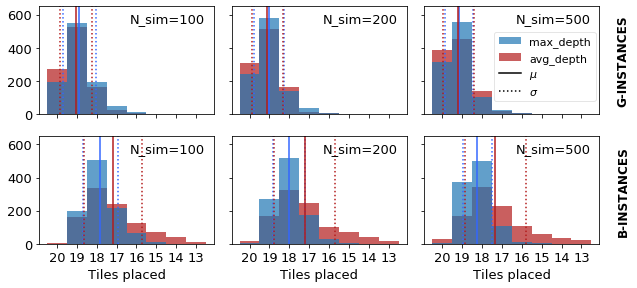

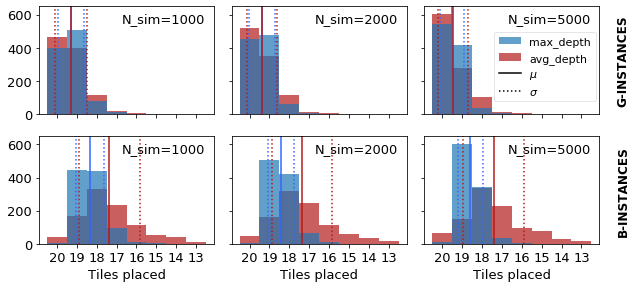

In [91]:
# scores_df
#f, axes = plt.subplots(4, 3, figsize=(11, 15))
from itertools import combinations
N_SIM = [100, 200, 500, 1000, 2000, 5000]
titles = {'guillotine': 'G-INSTANCES', 'florian': 'B-INSTANCES'}
plt.rcParams.update({'font.size': 13})
#colors = [ "#E64B35","#4DBBD5", "#00A087","#3C5488", "#F39B7F","#8491B4", "#91D1C2","#DC0000", "#7E6148","#B09C85" ]
colors = sns.color_palette()
# for color1, color2 in combinations(colors, 2):
for subp in range(0, 2):
    # plt.suptitle(titles[problem_type], y=1.02)
    f, axes = plt.subplots(2, 3, figsize=(9, 4.2))
    for p_type_index, problem_type in enumerate(['guillotine', 'florian']):
        j = p_type_index
        bins = np.arange(0, 9) - 0.5
        rows = len(N_SIM) // 2

        for i in range(3):
            if subp == 0:
                n_sim = N_SIM[i % 6]
            else:
                n_sim = N_SIM[(i + 3) % 6]
            common_args = {
                'score__isnull': False, 'improved_sel': True,
                'n_simulations': n_sim, 'solution_tiles_order__isnull': True
            }
            if problem_type == 'guillotine':
                common_args['problem_generator'] = 'guillotine'
                title = f'G instances (N_sim={n_sim})'
                avg_depth_scores = Result.objects.filter(problem_id__in=best_problem_ids, strategy='avg_depth', **common_args).values('score')
                max_depth_scores = Result.objects.filter(problem_id__in=best_problem_ids, strategy='max_depth', **common_args).values('score')
            else:
                title = f'B instances (N_sim={n_sim})'
                common_args['problem_generator'] = 'florian'
                avg_depth_scores = Result.objects.filter(their_id__in=best_their_ids, strategy='avg_depth', **common_args).values('score')
                max_depth_scores = Result.objects.filter(their_id__in=best_their_ids, strategy='max_depth', **common_args).values('score')

            avg_depth_scores_df = pd.DataFrame.from_records(avg_depth_scores)
            sns.distplot(score_to_int(avg_depth_scores_df),
                         kde=False, label='avg_depth',
                         color="#b31b1b",
                         hist_kws=dict(alpha=0.7),
                         bins=bins, ax=axes[j][i])
            max_depth_scores_df = pd.DataFrame.from_records(max_depth_scores)
            sns.distplot(score_to_int(max_depth_scores_df),
                              hist_kws=dict(alpha=0.7),
                              kde=False, label='max_depth', bins=bins, ax=axes[j][i])
            
           

            axes[j][i].set_ylim(0, 650)
            axes[j][i].xaxis.set_major_locator(ticker.MultipleLocator(1))
            axes[j][i].xaxis.set_major_formatter(ticker.ScalarFormatter())
            # plt.xlim(left=i)
            title = f'N_sim={n_sim}'
            axes[j][i].text(.95,.85,title,
                    horizontalalignment='right',
                    # verticalalignment='center',
                    transform=axes[j][i].transAxes)

            if i == 2:
                # _title = "\n".join([c for c in titles[problem_type]])
                _title = titles[problem_type]
                axes[j][i].text(1.10,.1, f'{_title}',
                        # horizontalalignment='right',
                        rotation='vertical',
                                weight='bold',
                        # verticalalignment='center',
                                size=12,
                        transform=axes[j][i].transAxes)
                
            # MEAN AND STDDEV
            color = '#3366ff'
            mean = max_depth_scores_df['score'].mean()
            stddev = max_depth_scores_df['score'].std()
            axes[j][i].axvline(mean - stddev, linestyle=':', color=color)
            axes[j][i].axvline(mean + stddev, linestyle=':', color=color)
            axes[j][i].axvline(mean, color=color)
            
            color = '#b31b1b'
            mean = avg_depth_scores_df['score'].mean()
            stddev = avg_depth_scores_df['score'].std()
            axes[j][i].axvline(mean - stddev, linestyle=':', color=color, label='$\sigma$')
            axes[j][i].axvline(mean + stddev, linestyle=':', color=color)
            axes[j][i].axvline(mean, color=color, label='$\mu$')
            
            #END MEAN AND STDDEV


            if problem_type == 'florian':
                axes[j][i].set_xlabel('Tiles placed')
                axes[j][i].set_xticklabels([21, 20, 19, 18, 17, 16, 15, 14, 13])
            else:
                axes[j][i].set_xticklabels([])
            if i == 0:
                pass
                # axes[j][i].set_ylabel(f'Number of solutions')
            if i > 0:
                axes[j][i].set_yticklabels([])
            if i == 2 and  problem_type == 'guillotine':
                handles, labels = axes[j][i].get_legend_handles_labels()
                handles = handles[::-1]
                labels = labels[::-1][:2]
                import matplotlib.lines as mlines
                mu_line = mlines.Line2D([], [], color='black')
                handles[2] = mu_line
                labels.append('$\mu$')
                sigma_line = mlines.Line2D([], [], color='black', linestyle=':')
                handles[3] = sigma_line
                labels.append('$\sigma$')
                axes[j][i].legend(handles, labels, loc=(0.4, 0.12), framealpha=0.5, fontsize=11)

    f.tight_layout()
    # plt.rcParams["figure.figsize"] = (8,5)
    plt.show()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


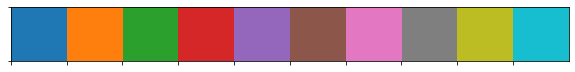

In [87]:
current_palette = sns.color_palette()
sns.palplot(current_palette)
print(current_palette)

### Simulation runs vs score

avg_depth
100 1000
avg_depth
200 1000
avg_depth
500 1000
avg_depth
1000 1000
avg_depth
2000 1000
avg_depth
5000 1000
[0 1 2 3 4 5]
OrderedDict([(100, {'median score': 0.982, 'median tiles placed': 250426.713, 'solutions found': 27.0}), (200, {'median score': 0.902, 'median tiles placed': 481892.065, 'solutions found': 30.7}), (500, {'median score': 0.803, 'median tiles placed': 1097593.859, 'solutions found': 38.800000000000004}), (1000, {'median score': 0.707, 'median tiles placed': 1977386.121, 'solutions found': 46.400000000000006}), (2000, {'median score': 0.633, 'median tiles placed': 3596924.235, 'solutions found': 51.800000000000004}), (5000, {'median score': 0.538, 'median tiles placed': 7443451.72, 'solutions found': 60.199999999999996})])
27.0	0.982	250426.713
30.7	0.902	481892.065
38.800000000000004	0.803	1097593.859
46.400000000000006	0.707	1977386.121
51.800000000000004	0.633	3596924.235
60.199999999999996	0.538	7443451.72
Number of tiles non-placed in correlation with sim

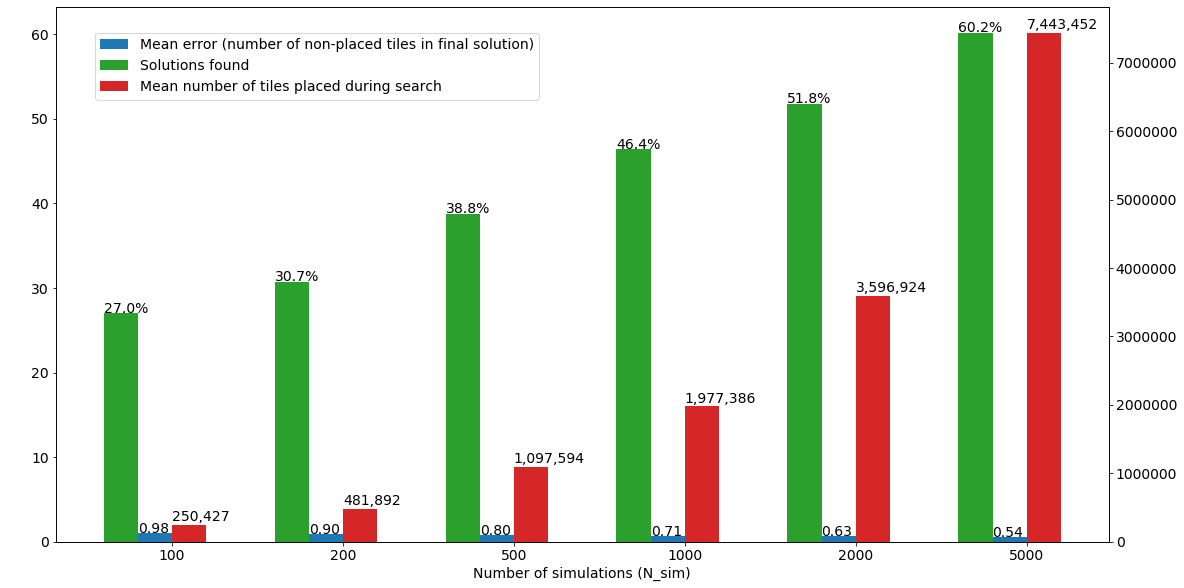

avg_depth
100 1000
avg_depth
200 1000
avg_depth
500 1000
avg_depth
1000 1000
avg_depth
2000 1000
avg_depth
5000 1000
[0 1 2 3 4 5]
OrderedDict([(100, {'median score': 2.817, 'median tiles placed': 260894.982, 'solutions found': 0.3}), (200, {'median score': 2.767, 'median tiles placed': 525212.695, 'solutions found': 1.7999999999999998}), (500, {'median score': 2.677, 'median tiles placed': 1320553.561, 'solutions found': 2.7}), (1000, {'median score': 2.642, 'median tiles placed': 2638119.848, 'solutions found': 4.2}), (2000, {'median score': 2.635, 'median tiles placed': 5276563.019, 'solutions found': 4.5}), (5000, {'median score': 2.583, 'median tiles placed': 13005113.878, 'solutions found': 6.3})])
0.3	2.817	260894.982
1.7999999999999998	2.767	525212.695
2.7	2.677	1320553.561
4.2	2.642	2638119.848
4.5	2.635	5276563.019
6.3	2.583	13005113.878
Number of tiles non-placed in correlation with simulation runs


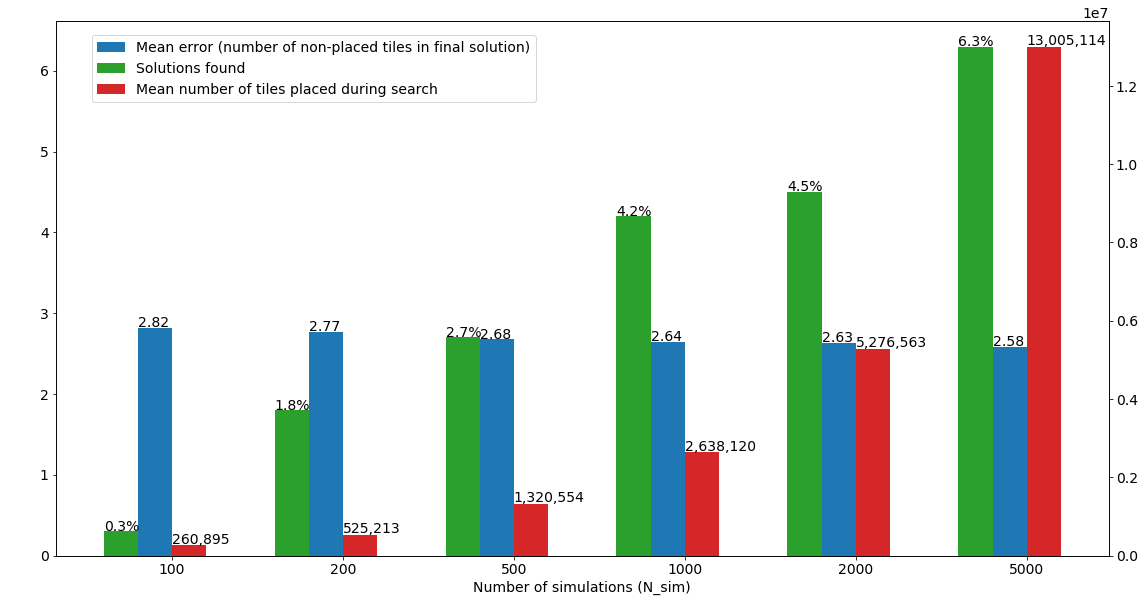

In [22]:
from collections import defaultdict, OrderedDict
from matplotlib.ticker import FuncFormatter, MaxNLocator
SIMULATION_RUNS = N_SIM
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(0, len(SIMULATION_RUNS)):
        return SIMULATION_RUNS[int(tick_val)]
    else:
        return ''
x_vals = defaultdict(list)
results = OrderedDict()

plt.rcParams["figure.figsize"] = (15,3)

for problem_type in ['g', 'b']:
    for n_simulations in SIMULATION_RUNS:
        common_args = {
            # 'problem_id__in': best_problem_ids,
            'strategy': 'avg_depth',
            'solution_tiles_order__isnull': True,
            'n_simulations': n_simulations,
            'improved_sel': True, 'score__isnull': False
        }
        print(common_args['strategy'])
        if problem_type == 'g':
            common_args['problem_id__in'] = best_problem_ids
        else:
            common_args['their_id__in'] = best_their_ids
        avg_score = np.average(np.array(Result.objects.filter(
            **common_args).order_by('their_id').values_list('score', flat=True)))
        results[n_simulations] = {'median score': avg_score}
        avg_tiles = np.average(np.array(Result.objects.filter(
            **common_args).order_by('their_id').values_list('n_tiles_placed', flat=True)))
        solutions_found = (Result.objects.filter(
            solution_found=True,**common_args).order_by('their_id').count() / 
            Result.objects.filter(**common_args).order_by('their_id').count() * 100)

        print(n_simulations, Result.objects.filter(**common_args).count())
        results[n_simulations]['median tiles placed'] = avg_tiles
        results[n_simulations]['solutions found'] = solutions_found

    fig,  ax1 = plt.subplots()
    x = np.arange(0, len(SIMULATION_RUNS) )
    print(x)
    y = np.arange(0,3)
    width_offset = 0.10
    width = 0.2 
    print(results)
    for k in [100, 200, 500, 1000, 2000, 5000]:
        print(f"{results[k]['solutions found']}\t{results[k]['median score']}\t{results[k]['median tiles placed']}")
    for i, score_type in enumerate(['median score', 'median tiles placed', 'solutions found']):
        # print(result)
        sc = [v[score_type] for k, v in results.items()]
        current_ax = ax1
        color = 'tab:blue'
        label = 'Mean error (number of non-placed tiles in final solution)'
        if i == 1:
            color = 'tab:red'
            ax2 = ax1.twinx()
            current_ax = ax2
            width_offset = -width_offset
            label = 'Mean number of tiles placed during search'
        if i == 2:
            color = 'tab:green'
            # ax2 = ax1.twinx()
            width_offset = -3 *  width_offset
            label = 'Solutions found'
        current_ax.bar(x - width_offset, sc, width=width, 
                label=label, color=color)
        if i != 2:
            current_ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
            current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        for j, v in enumerate(sc): 
            offset = width_offset 
            text = '{:.2f}'.format(v)
            _offset = 0.1
            _offset_top = 0.01
            if v >  100:
                text = '{:,.0f}'.format(v)
                _offset = 0.10
                _offset_top = 50000.35
            if i == 2:
                text = '{:.1f}%'.format(v)
                if problem_type == 'g':
                    _offset_top = 0.1
            current_ax.text(x[j] - offset - _offset, v + _offset_top, text)

    plt.rcParams["font.size"] = 14
    # plt.yticks(ticks=np.arange(0, 4))
    ax1.set_xlabel('Number of simulations (N_sim)')
    # ax1.set_ylabel('Median error (number of non-placed tiles in final solution)')
    # ax2.set_ylabel('Median number of tiles placed during search')
    fig.legend(loc=(0.08, 0.83))
    fig.subplots_adjust(top=2.6, right=1.1)
    print('Number of tiles non-placed in correlation with simulation runs')
    plt.show()

In [23]:
Result.objects.filter(n_simulations=2000).values('score', 'problem_id')


Result.objects.filter(n_simulations=1000).values('score', 'problem_id').filter(problem_id='eeca903e-157c-4f82-9c7f-ad75a41c6b1b')

<QuerySet []>

### Compare n_tiles

5 40 {'median score': 0.0}
6 40 {'median score': 0.0}
7 40 {'median score': 0.0}
8 40 {'median score': 0.0}
9 40 {'median score': 0.05}
10 40 {'median score': 0.025}
11 40 {'median score': 0.425}
12 40 {'median score': 0.45}
13 40 {'median score': 0.7}
14 40 {'median score': 0.875}
15 40 {'median score': 0.8}
16 40 {'median score': 1.675}
17 40 {'median score': 1.775}
18 40 {'median score': 1.375}
19 40 {'median score': 1.8}
20 40 {'median score': 0.25}
21 40 {'median score': 2.05}
22 40 {'median score': 1.925}
23 40 {'median score': 2.15}
24 40 {'median score': 2.15}
25 40 {'median score': 2.4}
26 40 {'median score': 3.5}
27 40 {'median score': 2.35}
28 40 {'median score': 2.475}
29 40 {'median score': 2.45}
30 40 {'median score': 2.725}
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30]
Number of tiles non-placed in correlation with simulation runs


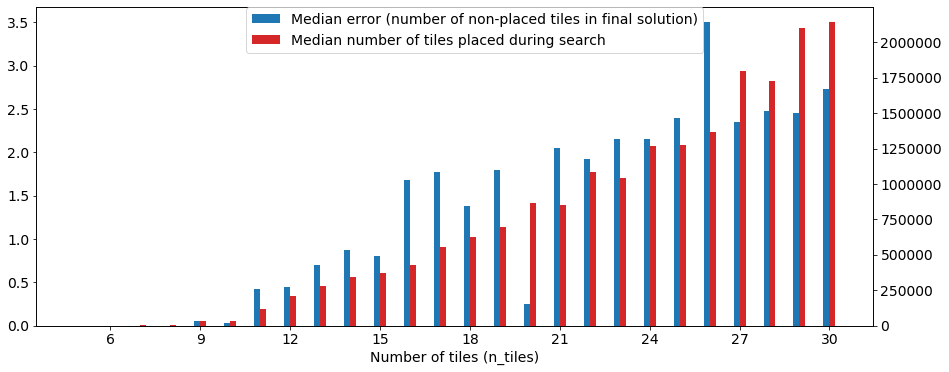

In [24]:
from collections import defaultdict, OrderedDict
from matplotlib.ticker import FuncFormatter, MaxNLocator

N_TILES = list(range(5, 31))

def format_fn(tick_val, tick_pos):
    return str(int(tick_val))
    if int(tick_val) in N_TILES:
        return N_TILES[int(tick_val)]
    else:
        return ''
    
x_vals = defaultdict(list)
results = OrderedDict()

plt.rcParams["figure.figsize"] = (15,3)

LAST_N_RECORDS = 40

for n_tiles in N_TILES:
    common_args = {
        'strategy': 'max_depth', 'n_tiles': n_tiles,
        'score__isnull': False, 'n_tiles_placed__isnull': False,
        'n_simulations': 1000, 'problem_generator': 'guillotine'
    }
    res_avg_score = Result.objects.filter(**common_args).order_by('-created_on').values_list('score', flat=True)[:LAST_N_RECORDS]
    if res_avg_score:
        avg_score = np.average(np.array(res_avg_score))
    else:
        avg_score = 0
    results[n_tiles] = {'median score': avg_score}
    
    res_tiles_placed = Result.objects.filter(**common_args).order_by('-created_on').values_list('n_tiles_placed', flat=True)[:LAST_N_RECORDS]
    if res_tiles_placed:
        avg_tiles = np.average(np.array(res_tiles_placed))
    else:
        avg_tiles = 0
    print(n_tiles, res_tiles_placed.count(), results[n_tiles])
    results[n_tiles]['median tiles placed'] = avg_tiles
    
fig,  ax1 = plt.subplots()
x = np.arange(N_TILES[0], N_TILES[-1] + 1)
print(x)
y = np.arange(0,3)
width_offset = 0.10
width = 0.2 
for i, score_type in enumerate(['median score', 'median tiles placed']):
    # print(result)
    sc = [v[score_type] for k, v in results.items()]
    current_ax = ax1
    color = 'tab:blue'
    label = 'Median error (number of non-placed tiles in final solution)'
    if i == 1:
        color = 'tab:red'
        ax2 = ax1.twinx()
        current_ax = ax2
        width_offset = -width_offset
        label = 'Median number of tiles placed during search'
    current_ax.bar(x - width_offset, sc, width=width, 
            label=label, color=color)
    current_ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # for i, v in enumerate(sc): 
    #     offset = width_offset 
    #     text = '{:.3f}'.format(v)
    #     _offset = 0.12
    #     _offset_top = 0.01
    #     if v >  10:
    #         text = '{:.0f}'.format(v)
    #         _offset = 0.10
    #         _offset_top = 50000.35
    #     current_ax.text(x[i] - offset - _offset, v + _offset_top, text)
   
plt.rcParams["font.size"] = 14
# plt.yticks(ticks=np.arange(0, 4))
ax1.set_xlabel('Number of tiles (n_tiles)')
# ax1.set_ylabel('Median error (number of non-placed tiles in final solution)')
# ax2.set_ylabel('Median number of tiles placed during search')
fig.legend(loc='upper center')
fig.subplots_adjust(top=1.6)
print('Number of tiles non-placed in correlation with simulation runs')
plt.show()

### Tiles placed (Huristic vs MCTS)

In [25]:
instances_where_solution_is_found = Result.objects.filter(solution_found=True, n_tiles=20, problem_generator='florian').values('n_tiles_placed', 'their_tiles_placed')
scores_df = pd.DataFrame.from_records(instances_where_solution_is_found)
scores_df

,n_tiles_placed,their_tiles_placed
0,661002,938
1,661002,938
2,873126,1396
3,873126,1396
4,463356,314
...,...,...
241,14302436,75
242,14302436,75
243,858933,29007
244,962642,22


In [26]:
STRATEGIES = ['avg_depth', 'max_depth']
common_args = {
    'n_tiles': 20, 
    'score__isnull': False, 
    'improved_sel': True,
    'their_id__in': best_their_ids
}
N_SIM = [100, 200, 500, 1000, 2000, 5000]
for strategy in STRATEGIES:
    for n_sim in N_SIM:
        solutions_found = Result.objects.filter(
            solution_found=True, problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).count()
        solutions_not_found = Result.objects.filter(
             problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).count()
        tiles_placed = np.average(np.array(Result.objects.filter(problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).values_list('n_tiles_placed', flat=True)))
        error = np.average(np.array(Result.objects.filter(problem_generator='florian', n_simulations=n_sim, strategy=strategy, **common_args).values_list('score', flat=True)))
        print(f'Florian instances with {n_sim} simulations and strategy {strategy}:')
        print(f'solutions found: {solutions_found} / {solutions_not_found} = {solutions_found / solutions_not_found * 100} %')
        print(f'tiles placed: {tiles_placed}')
        print(f'{solutions_found / solutions_not_found * 100 : .1f}% \t {int(round(tiles_placed)):,} \t {error}')
        print()

Florian instances with 100 simulations and strategy avg_depth:
solutions found: 3 / 1000 = 0.3 %
tiles placed: 260894.982
 0.3% 	 260,895 	 2.817

Florian instances with 200 simulations and strategy avg_depth:
solutions found: 18 / 1000 = 1.7999999999999998 %
tiles placed: 525212.695
 1.8% 	 525,213 	 2.767

Florian instances with 500 simulations and strategy avg_depth:
solutions found: 27 / 1000 = 2.7 %
tiles placed: 1320553.561
 2.7% 	 1,320,554 	 2.677

Florian instances with 1000 simulations and strategy avg_depth:
solutions found: 42 / 1000 = 4.2 %
tiles placed: 2638119.848
 4.2% 	 2,638,120 	 2.642

Florian instances with 2000 simulations and strategy avg_depth:
solutions found: 45 / 1000 = 4.5 %
tiles placed: 5276563.019
 4.5% 	 5,276,563 	 2.635

Florian instances with 5000 simulations and strategy avg_depth:
solutions found: 63 / 1000 = 6.3 %
tiles placed: 13005113.878
 6.3% 	 13,005,114 	 2.583

Florian instances with 100 simulations and strategy max_depth:
solutions found: 0

In [27]:
common_args = {
    'n_tiles': 20, 
    'score__isnull': False, 
    'improved_sel': True,
    'problem_id__in': best_problem_ids,
}

for strategy in STRATEGIES:
    for n_sim in N_SIM:
        print(f'Guillotine instances - {n_sim} - {strategy}:')
        solutions_found = Result.objects.filter(
            solution_found=True,  problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).count()
        solutions_not_found = Result.objects.filter(
            problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).count()
        tiles_placed = np.average(np.array(Result.objects.filter( problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).values_list('n_tiles_placed', flat=True)))
        error = np.average(np.array(Result.objects.filter( problem_generator='guillotine', n_simulations=n_sim, strategy=strategy, **common_args).values_list('score', flat=True)))
        
        print(f'solutions found: {solutions_found} / {solutions_not_found} = {solutions_found / solutions_not_found * 100} %')
        print(f'tiles placed: {tiles_placed}')
        print(f'error: {error}')
        print(f'{solutions_found / solutions_not_found * 100 : .1f}% \t {int(round(tiles_placed)):,} \t {error}')
        print()

Guillotine instances - 100 - avg_depth:
solutions found: 270 / 1000 = 27.0 %
tiles placed: 250426.713
error: 0.982
 27.0% 	 250,427 	 0.982

Guillotine instances - 200 - avg_depth:
solutions found: 307 / 1000 = 30.7 %
tiles placed: 481892.065
error: 0.902
 30.7% 	 481,892 	 0.902

Guillotine instances - 500 - avg_depth:
solutions found: 388 / 1000 = 38.800000000000004 %
tiles placed: 1097593.859
error: 0.803
 38.8% 	 1,097,594 	 0.803

Guillotine instances - 1000 - avg_depth:
solutions found: 464 / 1000 = 46.400000000000006 %
tiles placed: 1977386.121
error: 0.707
 46.4% 	 1,977,386 	 0.707

Guillotine instances - 2000 - avg_depth:
solutions found: 518 / 1000 = 51.800000000000004 %
tiles placed: 3596924.235
error: 0.633
 51.8% 	 3,596,924 	 0.633

Guillotine instances - 5000 - avg_depth:
solutions found: 602 / 1000 = 60.199999999999996 %
tiles placed: 7443451.72
error: 0.538
 60.2% 	 7,443,452 	 0.538

Guillotine instances - 100 - max_depth:
solutions found: 194 / 1000 = 19.40000000000

In [28]:
common_args = {
    'n_tiles': 20, 
    'score__isnull': False, 
    'improved_sel': True,
    'problem_id__in': best_problem_ids,
}
for strategy in STRATEGIES:
    for n_sim in N_SIM:
        average_tiles_placed_deterministic = Result.objects.filter(
            n_tiles=20, problem_generator='florian').aggregate(Avg('their_tiles_placed'))
        print('NG instances'); print('-' * 20)

        print('Florian tiles placed:', average_tiles_placed_deterministic)
        average_tiles_placed_deterministic = Result.objects.filter(
            n_tiles=20, problem_generator='florian', n_tiles_placed__isnull=False, strategy='max_depth').aggregate(Avg('n_tiles_placed'))
        print('MCTS tiles placed:', average_tiles_placed_deterministic); print()

        print('G instances'); print('-' * 20)
        average_tiles_placed_deterministic = Result.objects.filter(
            n_tiles=20, problem_generator='guillotine', n_tiles_placed__isnull=False, strategy='max_depth').aggregate(Avg('n_tiles_placed'))
        print('MCTS tiles placed:', average_tiles_placed_deterministic)

NG instances
--------------------
Florian tiles placed: {'their_tiles_placed__avg': 254867513.0079431}
MCTS tiles placed: {'n_tiles_placed__avg': 3527114.687912088}

G instances
--------------------
MCTS tiles placed: {'n_tiles_placed__avg': 2008383.7616768104}
NG instances
--------------------
Florian tiles placed: {'their_tiles_placed__avg': 254867513.0079431}
MCTS tiles placed: {'n_tiles_placed__avg': 3527114.687912088}

G instances
--------------------
MCTS tiles placed: {'n_tiles_placed__avg': 2008383.7616768104}
NG instances
--------------------
Florian tiles placed: {'their_tiles_placed__avg': 254867513.0079431}
MCTS tiles placed: {'n_tiles_placed__avg': 3527114.687912088}

G instances
--------------------
MCTS tiles placed: {'n_tiles_placed__avg': 2008383.7616768104}
NG instances
--------------------
Florian tiles placed: {'their_tiles_placed__avg': 254867513.0079431}
MCTS tiles placed: {'n_tiles_placed__avg': 3527114.687912088}

G instances
--------------------
MCTS tiles plac